# Pretraining of the Code Embedding by GloVe

In this notebook we try to use Keras backend implement the optimization problem of GloVe. 
$$J = \sum_{i, j=1}^{V}f(X_{ij})(\mathbf{w}_i^T\mathbf{v_j} + b_i + a_j - \log X_{ij})^2$$
$$ \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{a} = \text{argmin}(J)$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys
from importlib import reload
import scipy.sparse as sp
import time
import itertools
%matplotlib inline

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda, Multiply
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg, Parent_reg, preprocess
from glove import Glove

In [6]:
from ccs_tools import dx_multi, pr_multi, dx_label, core_dtypes_pd, dx_single

## Train Embedding with Co-occurences in AMI Cohort
### Reading Data

In [7]:
cohort='ami'
tst_seed=0

In [8]:
all_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [9]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

In [12]:
preprocessed = preprocess(all_df, DX_rarecutpoint=10, PR_rarecutpoint=5)

In [13]:
all_df = preprocessed['int_df']

In [17]:
tst_key = pd.read_csv(path+'cohorts/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

In [14]:
from glove import Glove

In [15]:
embed_dim=100
count_cap=5

In [16]:
g = Glove(input_dim=len(preprocessed['code_cat']), embedding_dim=embed_dim, count_cap=count_cap)

In [18]:
g.update_cooccur(train_df0[['DX1']+DXs+PRs])

Updating co-occurrence matrix from a Dataframe with 167841 rows...
Finished. It takes 29.3 seconds to update the cooccurrences.


In [19]:
cooccur_df = g.get_cooccur_df()

In [20]:
cooccur_df.shape

(874770, 3)

In [24]:
len(preprocessed['PR_cat'])

560

In [233]:
parent_pairs = preprocessed['parent_pairs']

In [234]:
g.train_glove(cooccur_df=cooccur_df, cache_path=model_path, epochs=50, earlystop_patience=10, reducelr_patience=3, 
              parent_pairs=parent_pairs, lamb=0., metric='cosine')

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/50
755859/755859 [==============================] - 8s 10us/step - loss: 1.1266
Epoch 2/50
755859/755859 [==============================] - 7s 9us/step - loss: 0.3318
Epoch 3/50
755859/755859 [==============================] - 7s 9us/step - loss: 0.2650
Epoch 4/50
755859/755859 [==============================] - 7s 9us/step - loss: 0.2308
Epoch 5/50
755859/755859 [==============================] - 7s 9us/step - loss: 0.2091
Epoch 6/50
755859/755859 [==============================] - 7s 9us/step - loss: 0.1934
Epoch 7/50
755859/755859 [==============================] - 7s 9us/step - loss: 0.1811
Epoch 8/50
755859/755859 [==============================] - 7s 9us/step - loss: 0.1712
Epoch 9/50
755859/755859 [==============================] - 7s 9us/step - loss: 0.1632
Epoch 10/50
755859/755859 [==============================] - 7s 9us/step - loss: 0.1567
Epoch 11/50
755859/755859 [===========================

## Get the cooccurrences from the whole database

In [7]:
from ccs_tools import dx_multi, pr_multi
from glove import Glove
from ccs_tools import core_cols, core_dtypes_pd, na_values

### Separate DX1

In [10]:
DX1_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE) + sorted(dx_multi.ICD9CM_CODE) + sorted(pr_multi.ICD9CM_CODE)

n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
n_code_cat = len(code_cat)

DX1_dict = dict(zip(DX1_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))

DXs = ['DX'+str(j) for j in range(2, 31)]
PRs = ['PR'+str(j) for j in range(1, 16)]

In [11]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [14]:
g = Glove(input_dim=len(code_cat), embedding_dim=100)

In [11]:
dxpr_df = pd.read_csv(path+'raw/2014/NRD_2014_Core.CSV', sep=',', 
                           header = None, 
                           names=core_cols, 
                           dtype=core_dtypes_pd, 
                           na_values=na_values, 
                           chunksize=500000)

In [15]:
chunk_id = 0
for df in dxpr_df:
    start = time.time()
    DX1_df = df[['DX1']]
    DX1_df = DX1_df.fillna('missing')
    DX1_df[DX1_df.isin(['invl', 'incn'])] = 'missing'
    DX1_df[DX1_df.isin(unclassified)] = 'missing'
    DX1_df['DX1'] = DX1_df['DX1'].map(DX1_dict)
    
    DX_df = df[DXs]
    DX_df = DX_df.fillna('missing')
    DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
    DX_df[DX_df.isin(unclassified)] = 'missing'
    for dx in DXs:
        DX_df[dx] = DX_df[dx].map(DX_dict)
        
    PR_df = df[PRs]
    PR_df = PR_df.fillna('missing')
    PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
    for pr in PRs:
        PR_df[pr] = PR_df[pr].map(PR_dict)
        
    df = pd.concat([DX1_df, DX_df, PR_df], axis=1)
    g.update_cooccur(df)
    print('Chunk {} finished. It takes {:.1f} seconds.'.format(chunk_id, time.time()-start))
    chunk_id += 1

Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 83.0 seconds to update the cooccurrences.
Chunk 0 finished. It takes 93.2 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 80.6 seconds to update the cooccurrences.
Chunk 1 finished. It takes 93.7 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 83.6 seconds to update the cooccurrences.
Chunk 2 finished. It takes 96.0 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 84.7 seconds to update the cooccurrences.
Chunk 3 finished. It takes 98.9 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 82.5 seconds to update the cooccurrences.
Chunk 4 finished. It takes 96.6 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 80.6 seconds to update the cooccurrences.
Chunk 5 finished. It takes 

In [16]:
cooccur_dict = g.get_cooccur_dict()

### Co-Occurence Matrices for cross-validation

In [20]:
ami_df = pd.read_csv(path+'cohorts/ami/ami_pred.csv', dtype=core_dtypes_pd)

In [26]:
for seed in range(1,10):
    print('Starting seed'+str(seed))
    train_df, tst_df = train_test_split(ami_df, test_size=0.1, stratify=ami_df.HOSP_NRD, random_state=seed)

    DX1_df = tst_df[['DX1']]
    DX1_df = DX1_df.fillna('missing')
    DX1_df[DX1_df.isin(['invl', 'incn'])] = 'missing'
    DX1_df[DX1_df.isin(unclassified)] = 'missing'
    DX1_df['DX1'] = DX1_df['DX1'].map(DX1_dict)
    
    DX_df = tst_df[DXs]
    DX_df = DX_df.fillna('missing')
    DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
    DX_df[DX_df.isin(unclassified)] = 'missing'
    for dx in DXs:
        DX_df[dx] = DX_df[dx].map(DX_dict)
        
    PR_df = tst_df[PRs]
    PR_df = PR_df.fillna('missing')
    PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
    for pr in PRs:
        PR_df[pr] = PR_df[pr].map(PR_dict)
        
    int_df = pd.concat([DX1_df, DX_df, PR_df], axis=1)

    g2 = Glove(input_dim=len(code_cat), embedding_dim=100)

    g2.update_cooccur(int_df)

    cooccur_dict_tst = g2.get_cooccur_dict()

    cooccur_dict0 = cooccur_dict.copy()

    for k, v in cooccur_dict_tst.items():
        cooccur_dict0[k] -= v
    print('Converting to cooccur_df...')
    pairs = list(cooccur_dict0.keys())
    counts = list(cooccur_dict0.values())
    focal, context = zip(*pairs)
    cooccur_df0 = pd.DataFrame(dict(focal_index=focal, context_index=context, cooccur_counts=counts), 
                              columns=['focal_index', 'context_index', 'cooccur_counts'])
    cooccur_df0 = cooccur_df0.loc[cooccur_df0.cooccur_counts>0]
    cooccur_df0.to_csv(path+'all/sepdx1/cooccur_df_ami'+str(seed)+'.csv', index=False)

Starting seed1
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 4.8 seconds to update the cooccurrences.
Converting to cooccur_df...


KeyboardInterrupt: 

### Adding Multi-Level Penalization

Separate DX1

In [45]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)

n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)

DX1_dict = dict(zip(DX_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))

DXs = ['DX'+str(j) for j in range(2, 31)]
PRs = ['PR'+str(j) for j in range(1, 16)]

unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories

code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)*2 + sorted(pr_multi.ICD9CM_CODE)+ sorted(dx_ccs_cat)[1:]*2 + sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)

dx1_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi), len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat))))
dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:]), 1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2)))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2, n_code_cat)))

In [46]:
parent_pairs = []
for dx in DX_cat[1:]:
    if not dx in unclassified:
        parent = dx_multi.loc[dx, 'finest_non_empty']
        parent_pairs.append((DX1_dict[dx], dx1_ccs_dict[parent]))
        parent_pairs.append((DX_dict[dx], dx_ccs_dict[parent]))
for pr in PR_cat[1:]:
    parent = pr_multi.loc[pr, 'finest_non_empty']
    parent_pairs.append((PR_dict[pr], pr_ccs_dict[parent]))
for c in dx_ccs_cat[1:]:
    parent = '.'.join(c.split('.')[:-1])
    if not parent=='':
        parent_pairs.append((dx1_ccs_dict[c], dx1_ccs_dict[parent]))
        parent_pairs.append((dx_ccs_dict[c], dx_ccs_dict[parent]))
for c in pr_ccs_cat[1:]:
    parent = '.'.join(c.split('.')[:-1])
    if not parent=='':
        parent_pairs.append((pr_ccs_dict[c], pr_ccs_dict[parent]))

In [9]:
g = Glove(input_dim=len(code_cat), embedding_dim=200)

In [10]:
cooccur_df = pd.read_csv(path+'all/sepdx1/cooccur_df_ami0.csv')

In [15]:
cooccur_df.shape

(17136813, 3)

In [12]:
g.train_glove(cooccur_df=cooccur_df, cache_path=model_path, epochs=30, reducelr_patience=2, parent_pairs=parent_pairs, lamb=0., 
              metric='cosine')

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/30
17136813/17136813 [==============================] - 238s 14us/step - loss: 0.1609
Epoch 2/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0412
Epoch 3/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0362
Epoch 4/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0342
Epoch 5/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0330
Epoch 6/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0322
Epoch 7/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0317
Epoch 8/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0313
Epoch 9/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0309
Epoch 10/30
17136813/17136813 [==============================] - 236s 14us/step 

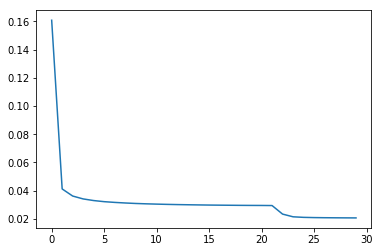

In [17]:
plt.plot(g.train_history.history['loss'])

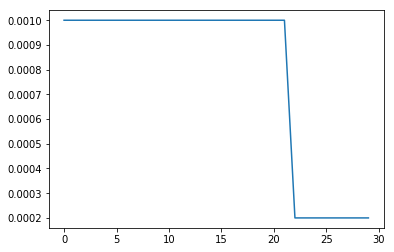

In [18]:
plt.plot(g.train_history.history['lr'])

In [20]:
embed_mat = g.get_embed_mat()

## Embedding Visualization

In [106]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [43]:
from collections import defaultdict

In [230]:
embed_mat = np.load(path+'all/sepdx1/test_embed/cosine/embed_mat_200_0.500_20_ami0.npy')

In [15]:
bias_mat = np.load(path+'all/sepdx1/test_embed/cosine/bias_mat_200_0.000_20_ami0.npy')

In [19]:
DX_bias_array = bias_mat[DX_dict[DX_cat[1]]:(DX_dict[DX_cat[-1]]+1), 0]

In [17]:
DX_marg_freq = pd.read_csv(path+'all/sepdx1/DX_marg_freq.csv')

In [79]:
DX_freq = pd.read_csv(path+'all/DX_freq.csv')
DX1_freq = pd.read_csv(path+'all/DX1_freq.csv')
PR_freq = pd.read_csv(path+'all/PR_freq.csv')

In [82]:
PR_freq.shape

(3948, 2)

In [206]:
sum(DX_freq.frequency<2000)/len(DX_freq), sum(DX1_freq.frequency<200)/len(DX1_freq), sum(PR_freq.frequency<1000)/len(PR_freq)

(0.8233811040339702, 0.8154193205944799, 0.7099797365754813)

In [205]:
DX_freq.loc[DX_freq.frequency<2000, 'frequency'].sum()/DX_freq.frequency.sum(), DX1_freq.loc[DX1_freq.frequency<200, 'frequency'].sum()/DX1_freq.frequency.sum(), PR_freq.loc[PR_freq.frequency<1000, 'frequency'].sum()/PR_freq.frequency.sum()

(0.019397460827959054, 0.01638032011006625, 0.018575044973067233)

In [231]:
low_freq_DXs = DX_freq.loc[DX_freq.frequency<1000, 'DX'].values
low_freq_DX1 = DX1_freq.loc[DX1_freq.frequency<100, 'DX1'].values
low_freq_PR = PR_freq.loc[PR_freq.frequency<500, 'PR'].astype(str).values

In [27]:
DX_marg_freq = DX_marg_freq.sort_values(by='DX')

DX bias vs. marginal frequency:

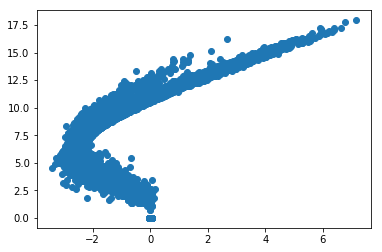

In [28]:
plt.scatter(DX_bias_array, np.log(DX_marg_freq.marg_freq.values+1))

Get marginal frequency:

In [198]:
cooccur_df = pd.read_csv(path+'all/sepdx1/cooccur_df0820.csv')

In [199]:
DX_freq_dict = defaultdict(float)

In [200]:
cooccur_df.head()

,focal_index,context_index,cooccur_counts
0,24701,1137,2.0
1,27577,18219,43.0
2,29464,18045,1.0
3,26365,25684,5.0
4,25636,8684,14.0


In [201]:
for _, row in cooccur_df.iterrows():
    DX_freq_dict[row.focal_index] += row.cooccur_counts
    DX_freq_dict[row.context_index] += row.cooccur_counts

In [202]:
len(DX_freq_dict)

25393

In [204]:
DX1_marg_freq = pd.DataFrame(dict(DX1=dx_multi.ICD9CM_CODE.values, 
                                  marg_freq=dx_multi.ICD9CM_CODE.apply(lambda x:DX_freq_dict[DX1_dict[x]])))
DX_marg_freq = pd.DataFrame(dict(DX=dx_multi.ICD9CM_CODE.values, 
                                  marg_freq=dx_multi.ICD9CM_CODE.apply(lambda x:DX_freq_dict[DX_dict[x]])))
PR_marg_freq = pd.DataFrame(dict(PR=pr_multi.ICD9CM_CODE.values, 
                                  marg_freq=pr_multi.ICD9CM_CODE.apply(lambda x:DX_freq_dict[PR_dict[x]])))

In [230]:
DX1_marg_freq.to_csv(path+'all/sepdx1/DX1_marg_freq.csv', index=False)
DX_marg_freq.to_csv(path+'all/sepdx1/DX_marg_freq.csv', index=False)
PR_marg_freq.to_csv(path+'all/sepdx1/PR_marg_freq.csv', index=False)

In [10]:
marg_freq = pd.read_csv(path+'all/sepdx1/marginal_freq.csv', dtype={'DX':bytes})
marg_freq = marg_freq.set_index(marg_freq.DX)

In [11]:
not_appear = marg_freq.loc[marg_freq.marg_freq==0, 'DX']

In [44]:
len(DX_freq_dict)

25393

In [13]:
embed_mat.shape

(35952, 200)

In [232]:
DX_cat_clean = [dx for dx in DX_cat if dx not in unclassified if dx not in low_freq_DXs]
DX1_cat_clean = [dx for dx in DX_cat if dx not in unclassified if dx not in low_freq_DX1]
PR_cat_clean = [pr for pr in PR_cat if pr not in low_freq_PR]
DX_cat_clean = DX_cat_clean[1:]
DX1_cat_clean = DX1_cat_clean[1:]
PR_cat_clean = PR_cat_clean[1:]

In [184]:
DX1_cat_clean = ami_DX

In [233]:
DX1_embed_mat = embed_mat[np.array([DX1_dict[dx] for dx in DX1_cat_clean]), :]
DX_embed_mat = embed_mat[np.array([DX_dict[dx] for dx in DX_cat_clean]), :]
PR_embed_mat = embed_mat[np.array([PR_dict[pr] for pr in PR_cat_clean]), :]

In [234]:
DX_embed_mat = np.concatenate([DX1_embed_mat, DX_embed_mat], axis=0)

In [235]:
tsne = TSNE(n_components=2, init='random', random_state=0)

In [236]:
start = time.time()
DX_tsne = tsne.fit_transform(DX_embed_mat)
print('Time used: {} sec'.format(time.time()-start))

Time used: 51.14935851097107 sec


In [190]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1]), index=DX_cat_clean)

ValueError: Shape of passed values is (2, 4371), indices imply (2, 4351)

In [237]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1], code_type=['major']*len(DX1_cat_clean)+['secondary']*len(DX_cat_clean)), 
                       index=DX1_cat_clean+DX_cat_clean)

CCS category labels:

In [238]:
plot_df = plot_df.assign(ccs_lvl1=[dx_multi.loc[dx, 'CCS_LVL1']+' '+dx_multi.loc[dx, 'CCS_LVL1_LABEL'] for dx in plot_df.index])

In [131]:
DX_freq = DX_freq.set_index(DX_freq.DX)
DX1_freq = DX1_freq.set_index(DX1_freq.DX1)

In [239]:
plot_df = plot_df.assign(freq=DX_freq.loc[plot_df.index, 'frequency'])

plot_df.loc[plot_df.code_type=='major', 'freq'] = DX1_freq.loc[plot_df.loc[plot_df.code_type=='major'].index, 'frequency']

In [241]:
plot_df = plot_df.assign(dot_size=plot_df.freq.apply(lambda x:np.log(x+1)**2/5))

In [242]:
plot_df.head(10)

,code_type,x,y,ccs_lvl1,freq,dot_size
0030,major,14.325519,22.423302,9 Diseases of the digestive system,1975,11.518068
0031,major,1.146928,-14.829253,1 Infectious and parasitic diseases,674,8.488296
0039,major,14.944878,21.928801,9 Diseases of the digestive system,158,5.138758
0043,major,15.072134,21.789172,9 Diseases of the digestive system,141,4.912044
0049,major,15.080152,21.774677,9 Diseases of the digestive system,244,6.052768
0059,major,14.264016,22.434430,9 Diseases of the digestive system,1532,10.760392
0071,major,14.897006,21.981346,9 Diseases of the digestive system,203,5.656480
0074,major,14.814658,22.072684,9 Diseases of the digestive system,310,6.589045
00800,major,14.985476,21.900671,9 Diseases of the digestive system,153,5.074178
00804,major,15.062149,21.808404,9 Diseases of the digestive system,176,5.358505


AMI cohort labels:

In [166]:
ami_DX = ['41000', '41001', '41010', '41011', '41020', '41021', '41030', '41031', '41040', '41041', '41050', '41051', '41060', '41061', '41070', '41071', '41080', '41081', '41090', '41091']

In [226]:
DX1_freq.loc[DX1_freq.DX1.isin(ami_DX)]

,DX1,frequency
DX1,,
41000,41000,19
41001,41001,5747
41010,41010,150
41011,41011,19656
41020,41020,12
41021,41021,4988
41030,41030,12
41031,41031,3159
41040,41040,128


In [167]:
rare_cause_ccs = ['97', '61', '62']
common_cause_ccs = ['49', '50', '53', '98', '99']

In [219]:
plot_df = plot_df.assign(label = 'other')

plot_df.loc[plot_df.index.isin(ami_DX) & (plot_df.code_type=='major'), 'label'] = 'AMI_major'

plot_df.loc[plot_df.index.isin(dx_single.loc[dx_single.CCS_CATEGORY.isin(common_cause_ccs), 'ICD9CM_CODE']) & 
            (plot_df.code_type=='secondary'), 'label'] = 'common_cause'

plot_df.loc[plot_df.index.isin(dx_single.loc[dx_single.CCS_CATEGORY.isin(rare_cause_ccs), 'ICD9CM_CODE']) &
            (plot_df.code_type=='secondary'), 'label'] = 'rare_cause'

In [146]:
ami_DX0 = [c for c in ami_DX if c[-1]=='0']
ami_DX1 = [c for c in ami_DX if c[-1]=='1']

plot_df.loc[plot_df.index.isin(ami_DX0), 'label'] = 'Major DX 410x0'
plot_df.loc[plot_df.index.isin(ami_DX1), 'label'] = 'Major DX 410x1'

Diabetes Mellitus, Hyperlipidemia, and Hypertension labels:

In [156]:
htn = [c for c in dx_label.dgns_cd.values if c.startswith('401')]
dm = [c for c in dx_label.dgns_cd.values if c.startswith('2500')]
hl = [c for c in dx_label.dgns_cd.values if c.startswith('2724')]

In [115]:
htn, dm, hl

(['4010', '4011', '4019'], ['25000', '25001', '25002', '25003'], ['2724'])

In [123]:
plot_df.loc[htn, 'label'] = 'Hypertension 401.xx'
plot_df.loc[dm, 'label'] = 'Diabetes Mellitus 250.0x'
plot_df.loc[hl, 'label'] = 'Hyperlipidemia 272.4x'

In [157]:
plot_df.loc[htn, 'label'] = dx_label.loc[htn, 'shortdesc']
plot_df.loc[dm, 'label'] = dx_label.loc[dm, 'shortdesc']
plot_df.loc[hl, 'label'] = dx_label.loc[hl, 'shortdesc']

In [165]:
plot_df.loc[htn, 'label'] = htn
plot_df.loc[dm, 'label'] = dm
plot_df.loc[hl, 'label'] = hl

In [166]:
plot_df.label.value_counts()

other    15064
4019         1
4010         1
25000        1
2724         1
25003        1
25001        1
4011         1
25002        1
Name: label, dtype: int64

In [162]:
colors = ['C{}'.format(j) for j in range(10)]

In [243]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('ccs_lvl1')
gkey = groups.size().sort_values(ascending=False).index

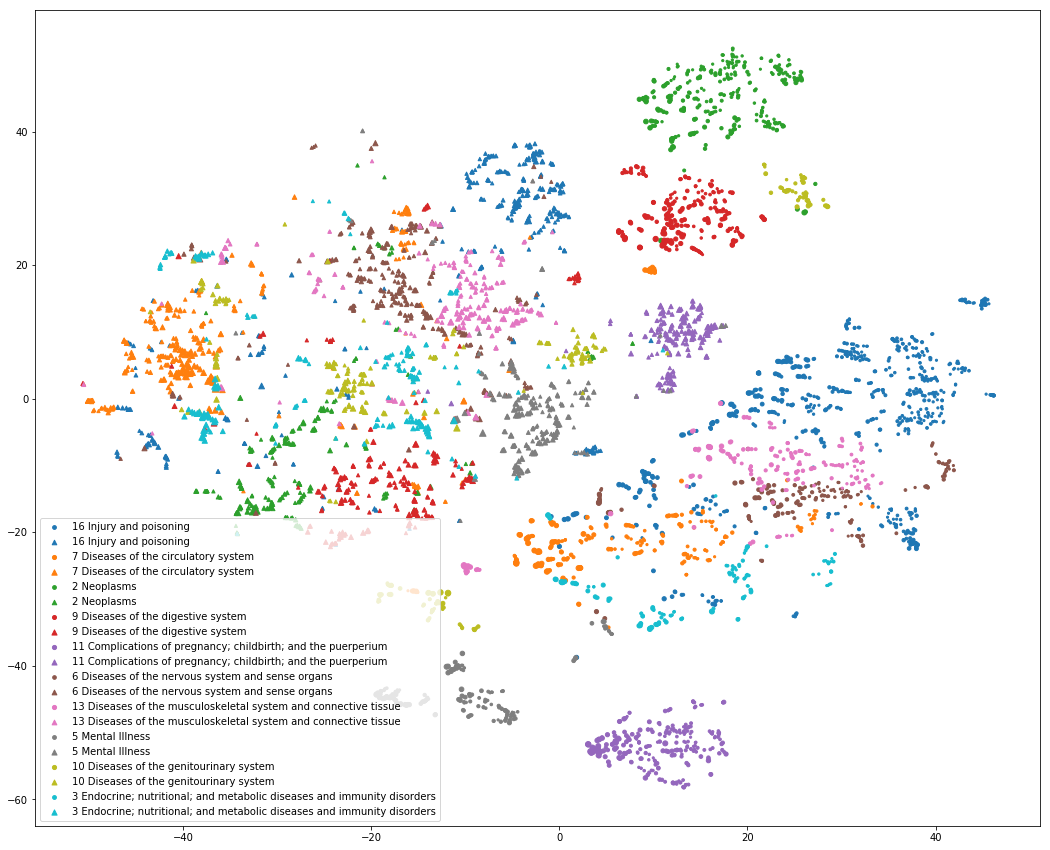

In [244]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey[:10], itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    g_major = group.loc[group.code_type=='major']
    g_secondary = group.loc[group.code_type=='secondary']
    ax.scatter(g_major.x, g_major.y, marker='o', s=g_major.dot_size.values, label=ccs_lvl1, c=color)
    ax.scatter(g_secondary.x, g_secondary.y, marker='^', s=g_secondary.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('output/embed.png', dpi=200)

In [222]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('label')
gkey = groups.size().index

In [199]:
gkey

Index(['AMI_major', 'common_cause', 'other', 'rare_cause'], dtype='object', name='label')

In [224]:
gkey = ['other', 'AMI_major', 'rare_cause', 'common_cause']

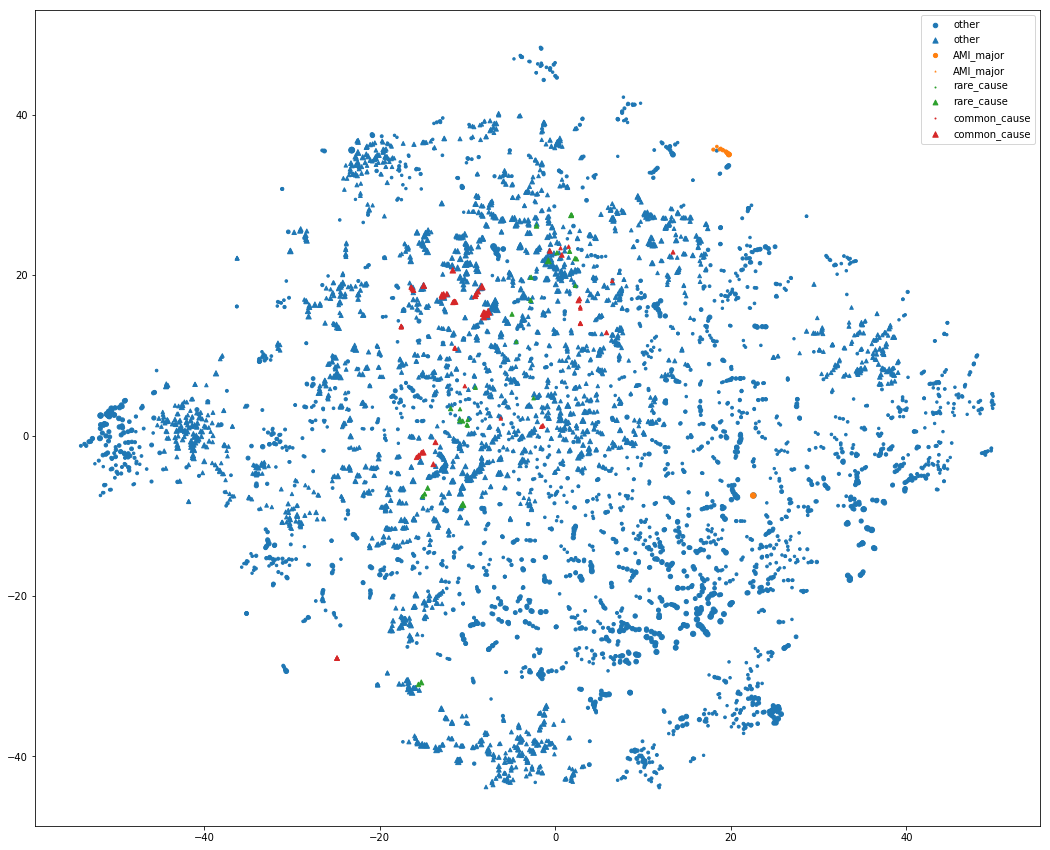

In [225]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey, itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    g_major = group.loc[group.code_type=='major']
    g_secondary = group.loc[group.code_type=='secondary']
    ax.scatter(g_major.x, g_major.y, marker='o', s=g_major.dot_size.values, label=ccs_lvl1, c=color)
    ax.scatter(g_secondary.x, g_secondary.y, marker='^', s=g_secondary.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('output/embed.png', dpi=200)

### backups

In [89]:
mat = K.variable(embed_mat)

In [90]:
mat.shape

TensorShape([Dimension(34093), Dimension(100)])

In [23]:
K.get_value(mat)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [92]:
embeds = K.gather(mat, code_ind)

In [93]:
embeds.shape

TensorShape([Dimension(18529), Dimension(100)])

In [94]:
parents = K.gather(mat, parent_ind)

In [95]:
parents.shape

TensorShape([Dimension(18529), Dimension(100)])

In [96]:
diff = embeds - parents

In [99]:
penalty = K.sum(K.square(diff))

In [100]:
K.get_value(penalty)

27770.062

In [34]:
K.get_value(submat)

array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)